In [1]:
import torch
import numpy as np
import torchvision
from torchvision import transforms
from pytorch_lightning import Trainer

from matplotlib import pyplot as plt

from datasets import Faces
from vae import VAE

In [2]:
input_shape = (1, 28, 28)
model = VAE(input_shape, dataset_name='mnist')
trainer = Trainer(gpus=1, max_epochs=10)       # Maybe set ~50 epochs for faces dataset

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


# Logging and visualizations
Model logs losses and recovered images into **TensorBoard**.  
Losses are logged every batch for both train and val datasets.  
Recovered images are logged after each epoch only for images in val dataset.  

In [8]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Reusing TensorBoard on port 6006 (pid 12280), started 5:34:51 ago. (Use '!kill 12280' to kill it.)

In [3]:
trainer.fit(model)


  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 10 M  
1 | decoder | Decoder | 5 M   
C:\Users\Sontref\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:25: UserWarning: Your val_dataloader has shuffle=True, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


1

# Sampling

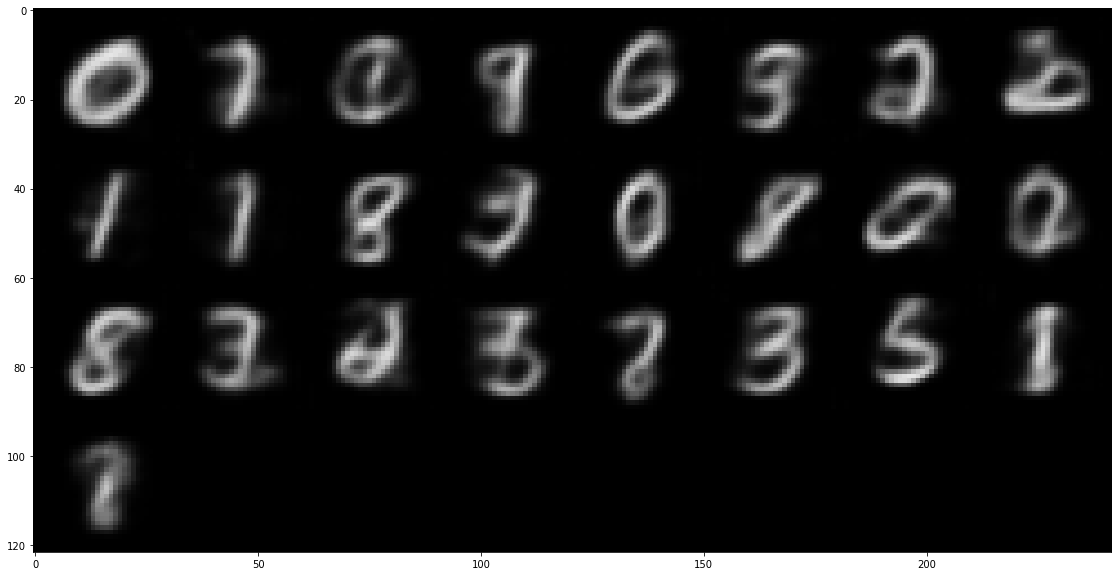

In [4]:
model.eval()
transforms_ = transforms.Compose([transforms.ToTensor()])
z = np.random.randn(25, 2048)
z = torch.from_numpy(z).float().to('cuda')
#z = model.decoder(z).view(25, 1, 28, 28)
grid = torchvision.utils.make_grid(z).detach().cpu()
plt.figure(figsize=(20,10))
plt.imshow(grid.permute(1, 2, 0))

# Latent representation

In [8]:
#transforms_ = transforms.Compose([transforms.ToTensor()])
#dataset = Faces('images/faces/', transforms_=transforms_, img_height=input_shape[1], img_width=input_shape[2])
transforms_ = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))])
mnist_train = torchvision.datasets.MNIST('images/mnist', train=True, download=True,
                transform=transforms_)
_, mnist_val = torch.utils.data.random_split(mnist_train, [55000, 5000])

In [39]:
model.eval()
model.to('cuda')
latent_vectors = []
labels = []
for img, label in mnist_val:
    img = img.view(1, *(img.shape)).to('cuda')
    mu, logsigma = model.encoder(img)
    latent_vectors.append(model.sampler(mu, logsigma).detach().cpu().numpy().flatten())
    labels.append(label)

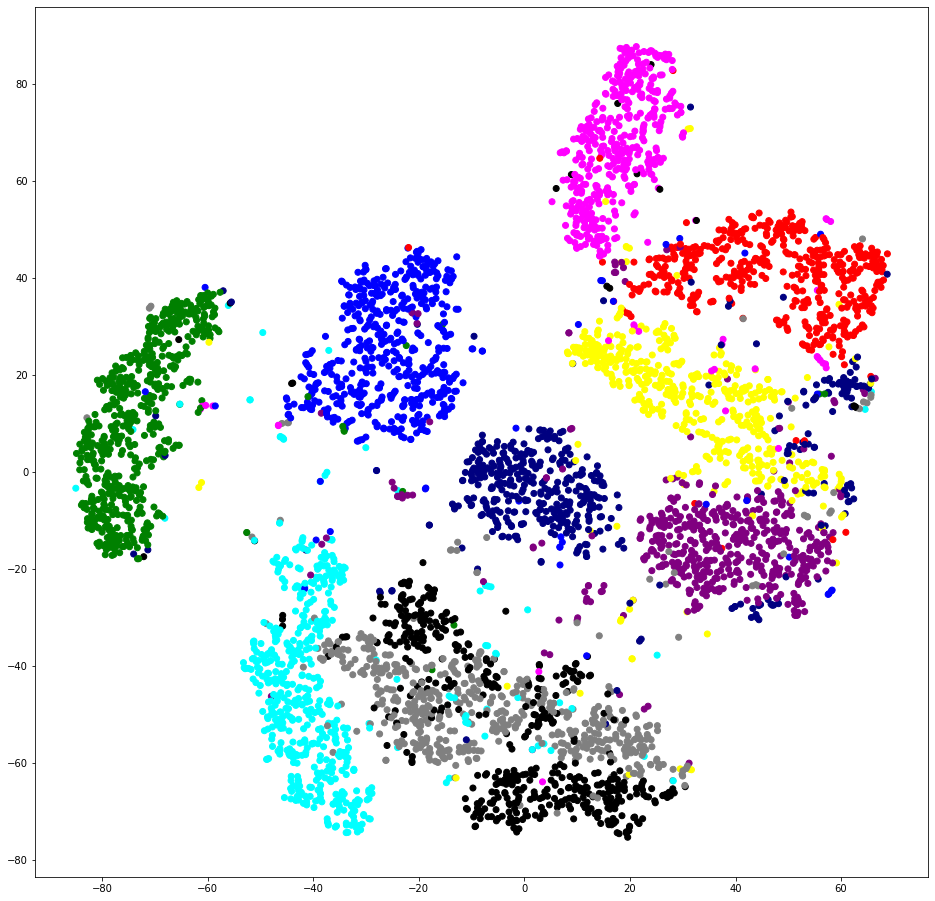

In [54]:
import matplotlib
from sklearn.manifold import TSNE

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=19)
new_values = tsne_model.fit_transform(latent_vectors)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

colors = ['red', 'green', 'blue', 'purple', 'black', 'yellow', 'magenta', 'cyan', 'navy', 'gray']
plt.figure(figsize=(16, 16)) 
plt.scatter(x, y, c=labels, cmap=matplotlib.colors.ListedColormap(colors))
plt.show()